<a href="https://colab.research.google.com/github/ajaysaikiran2208/Deep-Learning-Models/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Residual Network (ResNet) is one of the famous deep learning models that was introduced by Shaoqing Ren, Kaiming He, Jian Sun, and Xiangyu Zhang in their paper. The paper was named “Deep Residual Learning for Image Recognition” [1] in 2015. The ResNet model is one of the popular and most successful deep learning models so far.

Residual Blocks
The problem of training very deep networks has been relieved with the introduction of these Residual blocks and the ResNet model is made up of these blocks.

 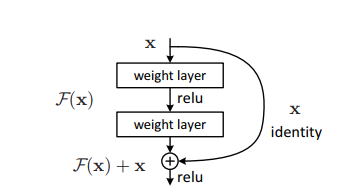


The problem of training very deep networks has been relieved with the introduction of these Residual blocks and the ResNet model is made up of these blocks.

In the above figure, the very first thing we can notice is that there is a direct connection that skips some layers of the model. This connection is called ’skip connection’ and is the heart of residual blocks. The output is not the same due to this skip connection. Without the skip connection, input ‘X gets multiplied by the weights of the layer followed by adding a bias term.

Then comes the activation function, f() and we get the output as H(x).

H(x)=f( wx + b ) or H(x)=f(x)

Now with the introduction of a new skip connection technique, the output is H(x) is changed to

H(x)=f(x)+x

But the dimension of the input may be varying from that of the output which might happen with a convolutional layer or pooling layers. Hence, this problem can be handled with these two approaches:

· Zero is padded with the skip connection to increase its dimensions.

· 1×1 convolutional layers are added to the input to match the dimensions. In such a case, the output is:

H(x)=f(x)+w1.x

Here an additional parameter w1 is added whereas no additional parameter is added when using the first approach.

These skip connections technique in ResNet solves the problem of vanishing gradient in deep CNNs by allowing alternate shortcut path for the gradient to flow through. Also, the skip connection helps if any layer hurts the performance of architecture, then it will be skipped by regularization.

Architecture of ResNet
There is a 34-layer plain network in the architecture that is inspired by VGG-19 in which the shortcut connection or the skip connections are added. These skip connections or the residual blocks then convert the architecture into the residual network as shown in the figure below.

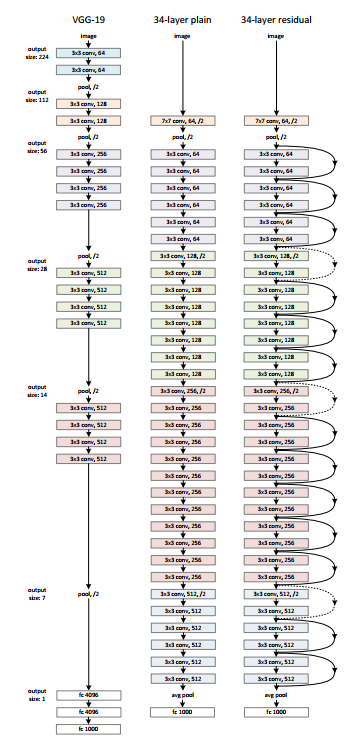

In [48]:
import torch
import torch.nn as nn


class block(nn.Module):
    def __init__(
        self, in_channels, intermediate_channels, identity_downsample=None, stride=1
    ):
        super(block, self).__init__()
        self.expansion = 4
        self.conv1 = nn.Conv2d(
            in_channels, intermediate_channels, kernel_size=1, stride=1, padding=0, bias=False
        )
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels,
            kernel_size=3,
            stride=stride,
            padding=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(
            intermediate_channels,
            intermediate_channels * self.expansion,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=False
        )
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet(nn.Module):
    def __init__(self, block, layers, image_channels, num_classes):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Essentially the entire ResNet architecture are in these 4 lines below
        self.layer1 = self._make_layer(
            block, layers[0], intermediate_channels=64, stride=1
        )
        self.layer2 = self._make_layer(
            block, layers[1], intermediate_channels=128, stride=2
        )
        self.layer3 = self._make_layer(
            block, layers[2], intermediate_channels=256, stride=2
        )
        self.layer4 = self._make_layer(
            block, layers[3], intermediate_channels=512, stride=2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * 4, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)

        return x

    def _make_layer(self, block, num_residual_blocks, intermediate_channels, stride):
        identity_downsample = None
        layers = []

        # Either if we half the input space for ex, 56x56 -> 28x28 (stride=2), or channels changes
        # we need to adapt the Identity (skip connection) so it will be able to be added
        # to the layer that's ahead
        if stride != 1 or self.in_channels != intermediate_channels * 4:
            identity_downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels,
                    intermediate_channels * 4,
                    kernel_size=1,
                    stride=stride,
                    bias=False
                ),
                nn.BatchNorm2d(intermediate_channels * 4),
            )

        layers.append(
            block(self.in_channels, intermediate_channels, identity_downsample, stride)
        )

        # The expansion size is always 4 for ResNet 50,101,152
        self.in_channels = intermediate_channels * 4

        # For example for first resnet layer: 256 will be mapped to 64 as intermediate layer,
        # then finally back to 256. Hence no identity downsample is needed, since stride = 1,
        # and also same amount of channels.
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels))

        return nn.Sequential(*layers)


def ResNet50(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 6, 3], img_channel, num_classes)


def ResNet101(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 4, 23, 3], img_channel, num_classes)


def ResNet152(img_channel=3, num_classes=1000):
    return ResNet(block, [3, 8, 36, 3], img_channel, num_classes)


def test():
    net = ResNet101(img_channel=3, num_classes=1000)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    y = net(torch.randn(4, 3, 224, 224)).to(device)
    print(y.size())


test()


torch.Size([4, 1000])
